In [3]:
import numpy as np 
import scipy, h5py
import tables
import sys
from scipy.optimize import minimize
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
import os

In [148]:
import os
import tables
def findfile(radius):
    filename = '../coeff_time_1t_10000_5/file_' + radius + '.h5'
    #print(filename)
    h = tables.open_file(filename,'r')
    coeff = np.array(h.root.coeff)[:]
    ft = np.array(h.root.ft)[:]
    ch = np.array(h.root.ch)[:]
    predict = np.array(h.root.predict)[:]
    h.close()
    return coeff, ft, ch, predict

coeff = [];
ft = [];
ch = [];
predict = [];
radius = np.arange(0.4001,0.40,-0.01)
for i in radius:
    file_str = '%+.2f' % i
    a1,a2,a3,a4 = findfile(file_str)
    a1 = findfile(file_str)
    coeff.append(a1)
    ft.append(a2)
    ch.append(a3)
    predict.append(a4)
time_coeff = np.array(coeff)

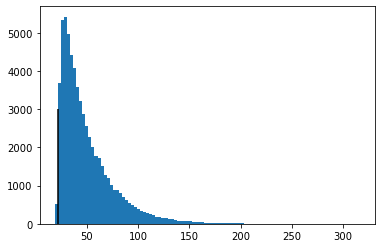

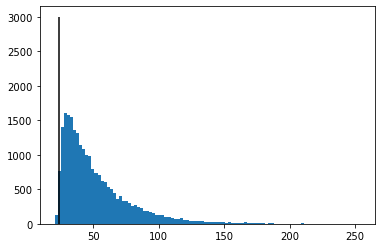

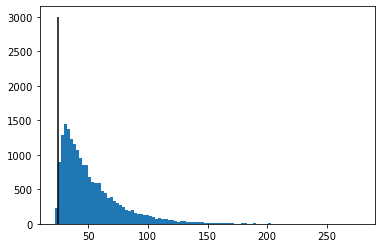

In [149]:
for N in range(1,30,10):
    plt.hist(np.array(ft)[0,np.array(ch)[0]==N],bins=100)
    plt.vlines(np.array(predict)[0,0,N],0,3e3)
    plt.show()

In [127]:
def Calib(theta, *args):
    flight_time = args
    y = flight_time
    #print(y)
    #print(theta)
    L = np.sum(Likelihood_quantile(y[0], theta, 0.01, 0.3))
    
    return L

def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i - y[y<T_i]
    more = y[y>=T_i] - T_i
    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    return R

record = []
for N in range(30):
    '''
    plt.hist(np.array(ft)[0,np.array(ch)[0]==N],bins=100)
    plt.vlines(np.array(predict)[0,0,N],0,3e3)
    plt.show()
    '''
    theta0 = 0 # initial value
    data = (np.array(ft)[0,np.array(ch)[0]==N])
    result = np.quantile(data, 0.01)  
    record.append(result)
    print(record[N], np.array(predict)[0,0,N])

21.585687826962808 21.57180101961681
22.028126534602883 21.982967693748165
22.750435499833383 22.67923630021891
23.526037256024217 23.509248602834795
24.057031351175038 24.05670985211236
24.17190322783803 24.18959192898572
24.475608651914236 24.458010064363435
25.71290559309128 25.72791802216214
21.293825005158503 21.293674046271263
23.12001801664171 23.130209375258385
22.990486816146102 22.925946828770716
23.501762839229063 23.509248602834795
23.952632575895812 23.948949494713712
24.440169671806665 24.458010064363435
25.07699830912248 25.188339929722186
25.75164007366806 25.72791802216214
21.558332283010692 21.57180101961681
22.878555655811116 22.925946828770716
23.147782808884074 23.130209375258385
23.38776567972153 23.327764375023992
23.953450003617135 23.948949494713712
24.431707933854895 24.50348631341929
25.023637879546406 25.0170965747841
25.309038426939928 25.188339929722186
21.93439485287452 21.982967693748165
22.609058675880455 22.67923630021891
23.298085587092977 23.32776437

(array([1., 2., 0., 0., 2., 0., 0., 0., 0., 2., 0., 2., 2., 2., 2., 0., 0.,
        2., 2., 2., 0., 4., 0., 0., 0., 1., 2., 0., 0., 2.]),
 array([21.29367405, 21.44148218, 21.58929031, 21.73709844, 21.88490658,
        22.03271471, 22.18052284, 22.32833097, 22.47613911, 22.62394724,
        22.77175537, 22.9195635 , 23.06737164, 23.21517977, 23.3629879 ,
        23.51079603, 23.65860417, 23.8064123 , 23.95422043, 24.10202856,
        24.2498367 , 24.39764483, 24.54545296, 24.69326109, 24.84106923,
        24.98887736, 25.13668549, 25.28449362, 25.43230176, 25.58010989,
        25.72791802]),
 <a list of 30 Patch objects>)

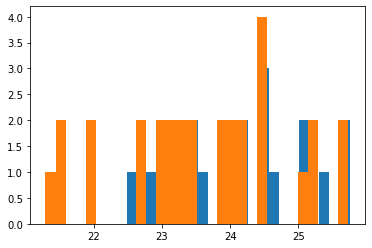

In [128]:
plt.hist(record,bins=30)
plt.hist(predict[0][0],bins=30)

In [123]:
predict[0][0][0]

21.829320311611895

In [143]:
import numpy as np 
import scipy, h5py
import tables
import sys
from scipy.optimize import minimize
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
import os

def Calib(theta, *args):
    ChannelID, flight_time, PMT_pos, cut = args
    y = flight_time
    x = Legendre_coeff(PMT_pos)
    Legend_coeff = x[ChannelID,:]
    T_i = np.dot(Legend_coeff, theta)
    L = Likelihood_quantile(y, T_i, 0.01, 0.3)

    return L

def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i[y<T_i] - y[y<T_i]
    more = y[y>=T_i] - T_i[y>=T_i]
    
    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    #log_Likelihood = exp
    return R

def Legendre_coeff(PMT_pos):
    vertex = np.array([0,0,2,10])
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1) \
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1
    size = np.size(PMT_pos[:,0])
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_theta,c)
    return x  

def main_Calib(radius):
    filename = '/mnt/stage/douwei/Simulation/1t_root/1MeV_10000_h5/1t_' + radius + '.h5'

    # read files by table
    h1 = tables.open_file(filename,'r')
    print(filename)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    PETime = truthtable[:]['PETime']
    photonTime = truthtable[:]['photonTime']
    PulseTime = truthtable[:]['PulseTime']
    dETime = truthtable[:]['dETime']
    h1.close()
    
    # read file series
    
    try:
        for j in np.arange(1,10,1):
            filename = Energy + '/calib' + radius + '_' + str(j)+ '.h5'           
            h1 = tables.open_file(filename,'r')
            print(filename)
            truthtable = h1.root.GroundTruth

            EventID_tmp = truthtable[:]['EventID']
            ChannelID_tmp = truthtable[:]['ChannelID']
            PETime_tmp = truthtable[:]['PETime']
            photonTime_tmp = truthtable[:]['photonTime']
            PulseTime_tmp = truthtable[:]['PulseTime']
            dETime_tmp = truthtable[:]['dETime']
            
            EventID = np.hstack((EventID, EventID_tmp))
            ChannelID = np.hstack((ChannelID, ChannelID_tmp))
            PETime = np.hstack((PETime, PETime_tmp))
            photonTime = np.hstack((photonTime, photonTime_tmp))
            PulseTime = np.hstack((PulseTime, PulseTime_tmp))
            dETime = np.hstack((dETime, dETime_tmp))
            
            h1.close()
    except:
        j = j - 1
    
    total_pe = np.zeros((np.size(PMT_pos[:,0]),max(EventID)))
    
    flight_time = PulseTime - dETime
    ChannelID = ChannelID[~(flight_time==0)]
    flight_time = flight_time[~(flight_time==0)]
    theta0 = np.zeros(cut) # initial value
    theta0[0] = np.mean(flight_time) - 26
    result = minimize(Calib,theta0, method='SLSQP',args = (ChannelID, flight_time, PMT_pos, cut))  
    record = np.array(result.x, dtype=float)
    print(result.x)
    
    ft = np.zeros(30)
    for ch in np.arange(30):
        ft[ch] = np.quantile(flight_time[ChannelID==ch],0.01)

    x = Legendre_coeff(PMT_pos)
    predict = [];
    predict.append(np.dot(x, result.x))
    return predict, ft

f = open(r'../PMT_1t.txt')
line = f.readline()
data_list = []
while line:
    num = list(map(float,line.split()))
    data_list.append(num)
    line = f.readline()
    
f.close()
PMT_pos = np.array(data_list)

cut = 5 # Legend order
predict, ft = main_Calib('+0.40')


/mnt/stage/douwei/Simulation/1t_root/1MeV_10000_h5/1t_+0.40.h5
[23.61737417 -2.19387732 -0.14880774 -0.28116261  0.06616573]


In [144]:
np.sum(predict[0]-ft)

-0.005682895566028634

In [145]:
ft

array([21.58568783, 22.02812653, 22.7504355 , 23.52603726, 24.05703135,
       24.17190323, 24.47560865, 25.71290559, 21.29382501, 23.12001802,
       22.99048682, 23.50176284, 23.95263258, 24.44016967, 25.07699831,
       25.75164007, 21.55833228, 22.87855566, 23.14778281, 23.38776568,
       23.95345   , 24.43170793, 25.02363788, 25.30903843, 21.93439485,
       22.60905868, 23.29808559, 24.20911341, 24.05958302, 24.5826667 ])

In [146]:
predict[0]

array([21.56338901, 21.95241636, 22.72795666, 23.51391523, 24.02234484,
       24.20743231, 24.39999297, 25.66882094, 21.31014473, 23.15131927,
       22.89799795, 23.51391523, 23.90782033, 24.39999297, 25.28780657,
       25.66882094, 21.56338901, 22.89799795, 23.15131927, 23.38135795,
       23.90782033, 24.52706567, 25.08334244, 25.28780657, 21.95241636,
       22.72795666, 23.38135795, 24.20743231, 24.02234484, 24.52706567])